In [79]:
import cv2
import matplotlib.pyplot as plt
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import yolov5
import pandas
import numpy as np

In [2]:
temp_list = []
cap= cv2.VideoCapture("renders/teatime/2023-05-04_172102.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if (ret == False): break
    temp_list.append(frame)
cap.release()
cv2.destroyAllWindows()

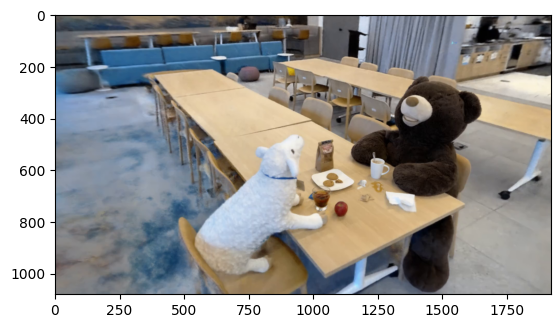

In [6]:
plt.imshow(temp_list[0][:,:,::-1])

In [7]:
import PIL

In [196]:
img = temp_list[0][:,:,::-1]
input_img = PIL.Image.fromarray(img.astype('uint8'), 'RGB')
print(img.shape)

(1080, 1920, 3)


In [133]:
def load_yolo5_model():
    """
    Returns:
        Yolo5 model. see https://github.com/fcakyon/yolov5-pip for documentation
    """
    model = yolov5.load('yolov5s.pt')
    model.conf = 0.25  # NMS confidence threshold
    model.iou = 0.45  # NMS IoU threshold
    model.agnostic = False  # NMS class-agnostic
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 20  # maximum number of detections per image
    return model


yolo = load_yolo5_model()

In [16]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-tiny')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')

inputs = feature_extractor(images=input_img, return_tensors="pt")
outputs = model(**inputs)

/n/fs/nlp-jiatongy/miniconda3/envs/nerf/lib/python3.8/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [70]:
predictions = yolo(input_img).pred[0]

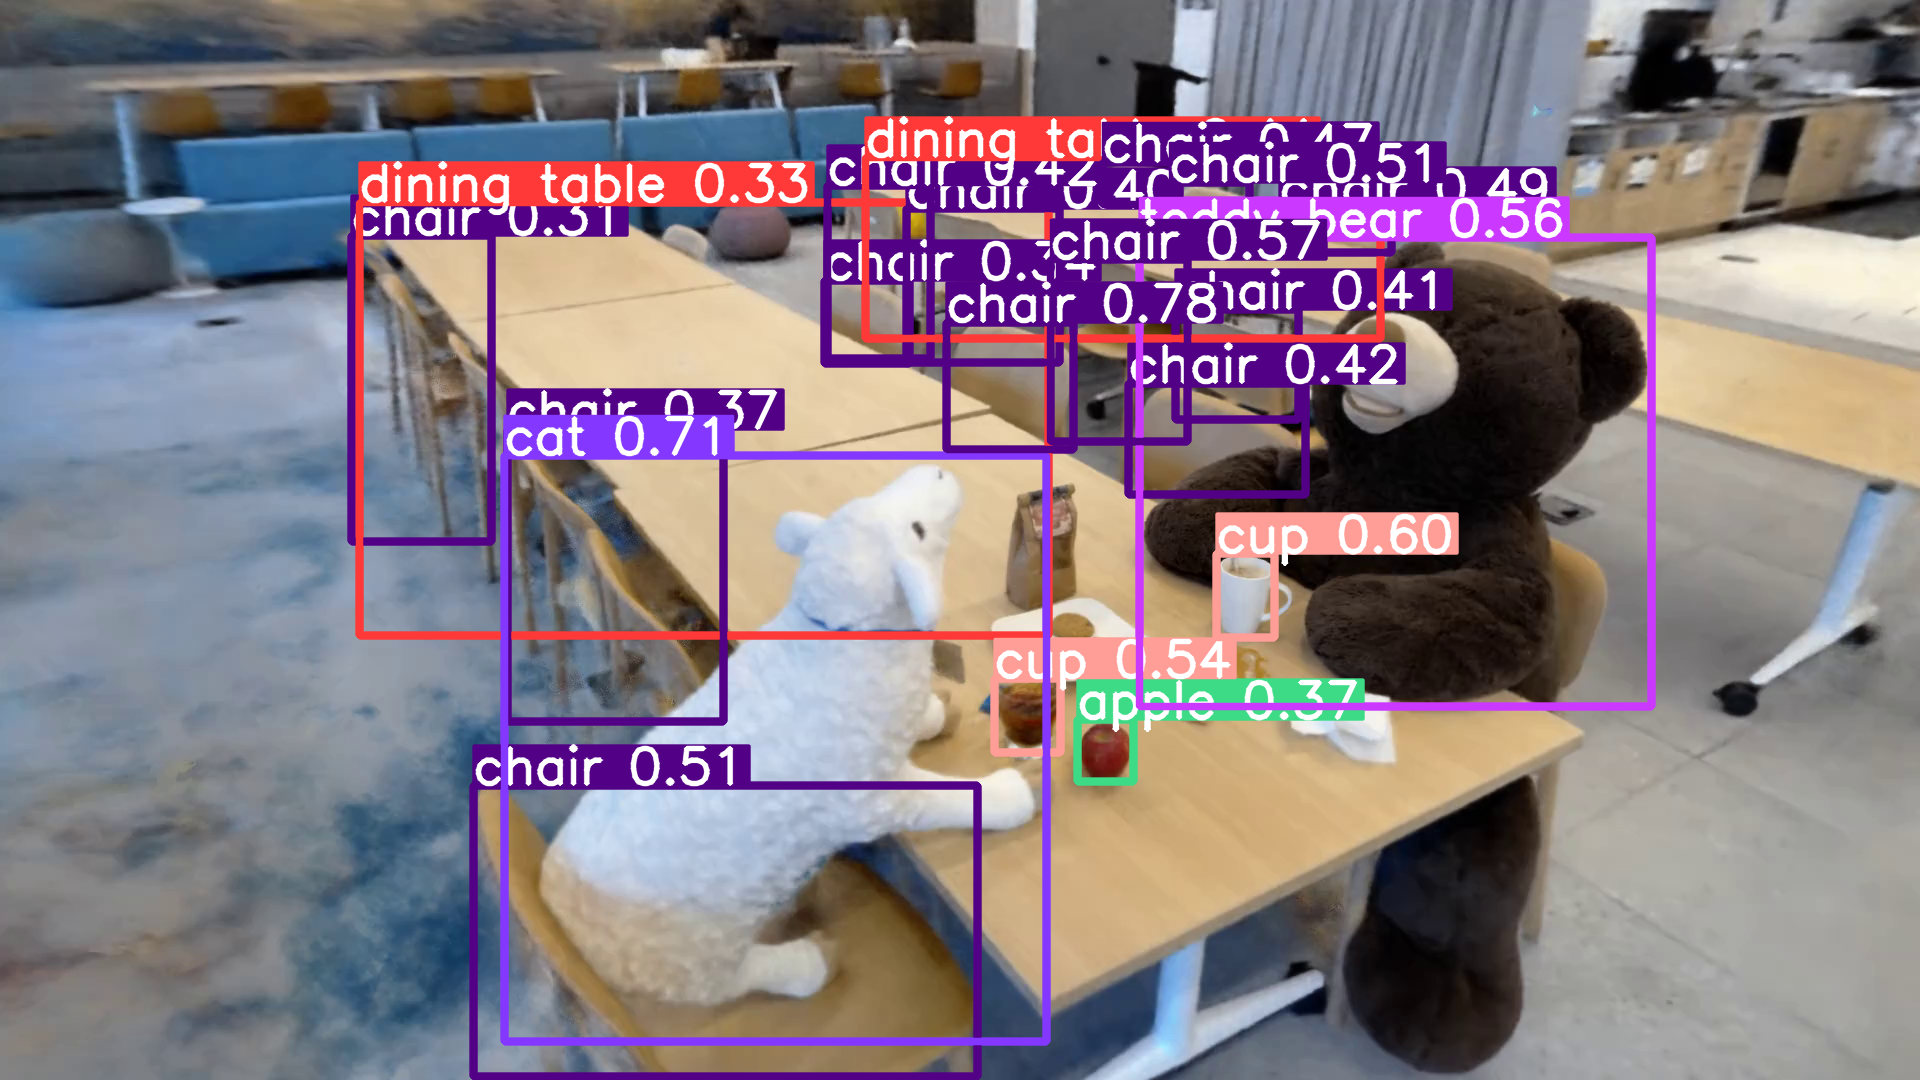

In [62]:
predictions.show()

In [139]:
box = predictions[int((predictions[:,5] == 47).nonzero(as_tuple=True)[0])][:4] #x1,y1,x2,y2
int(box[1])

719

In [173]:
mask = img.copy()
mask = cv2.rectangle(mask,pt1=(int(box[0]),int(box[1])),pt2=(int(box[2]),int(box[3])),color=(0,)*3,thickness=-1)

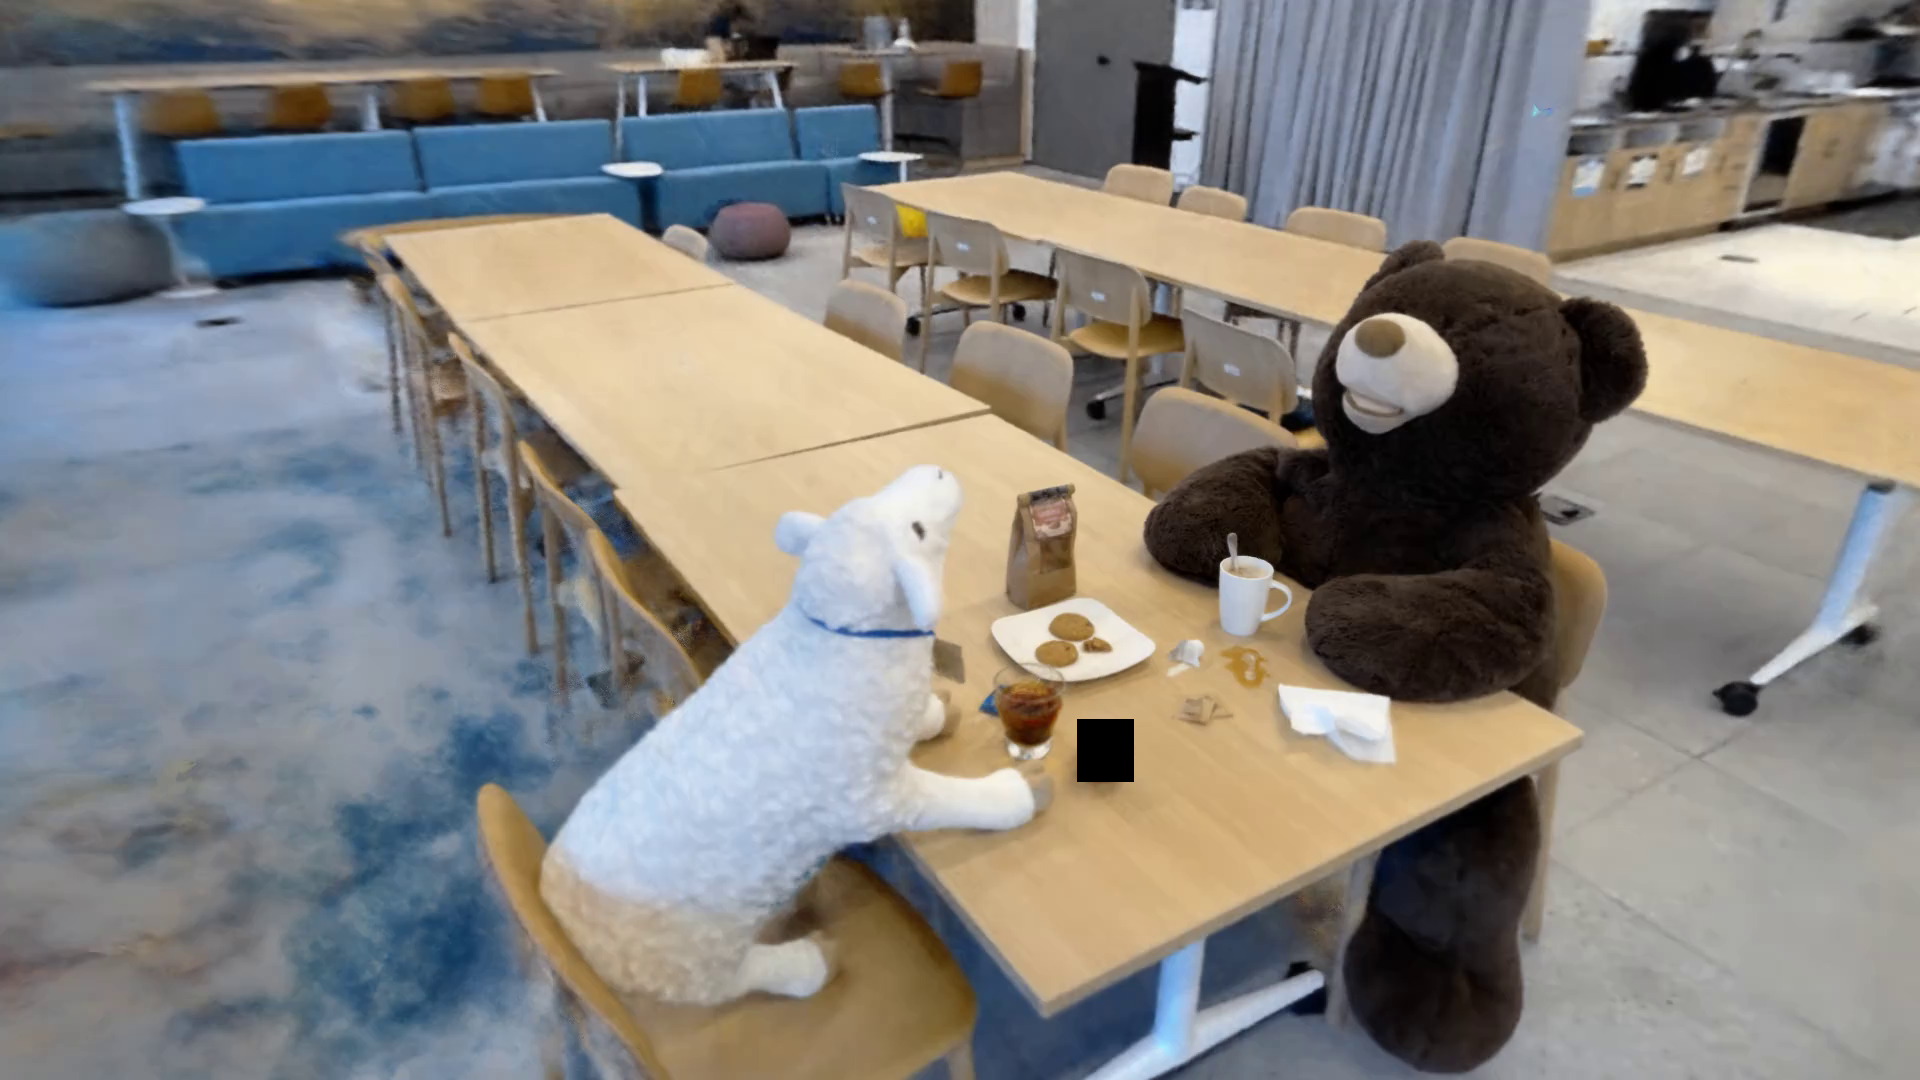

In [174]:
PIL.Image.fromarray(cv2.bitwise_and(img,mask).astype('uint8'),'RGB')

In [175]:
masked_input_img = PIL.Image.fromarray(cv2.bitwise_and(img,mask).astype('uint8'),'RGB')

In [179]:
masked_img = cv2.bitwise_and(img,mask)

In [183]:
masked_img.shape == img.shape

True

In [122]:
from diffusers import StableDiffusionInpaintPipeline
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/n/fs/nlp-jiatongy/miniconda3/envs/nerf/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [201]:
prompt = "a triangle on the table"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=input_img.resize((512,512)),
    mask_image=masked_input_img.resize((512,512)),
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [190]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [203]:
images.insert(0, input_img.resize((512,512)))

In [204]:
image_grid(images, 1, num_samples + 1)

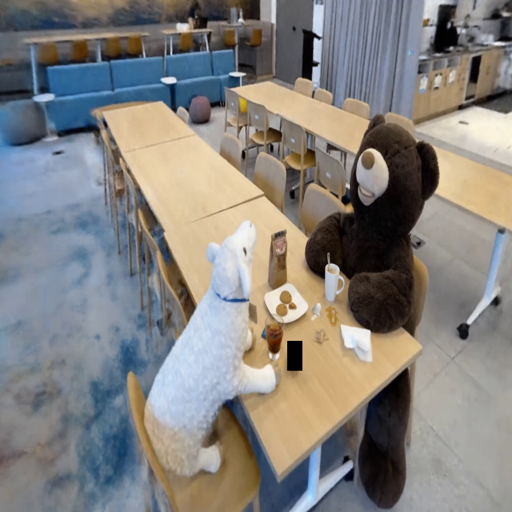

In [194]:
masked_input_img.resize((512,512))